In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load Dataset
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

# Show first rows
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Check Missing Values
train_df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# EDA - Survival distribution
sns.countplot(data=train_df, x="Survived")
plt.title("Survival Distribution")
plt.show()

In [ ]:
# Survival vs Pclass
sns.countplot(data=train_df, x="Pclass", hue="Survived")
plt.title("Survival by Passenger Class")
plt.show()

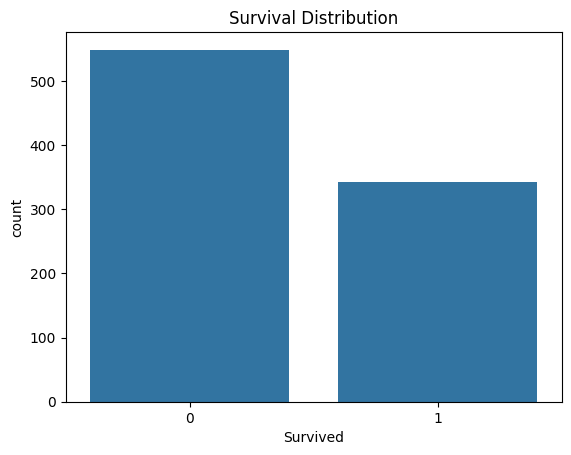

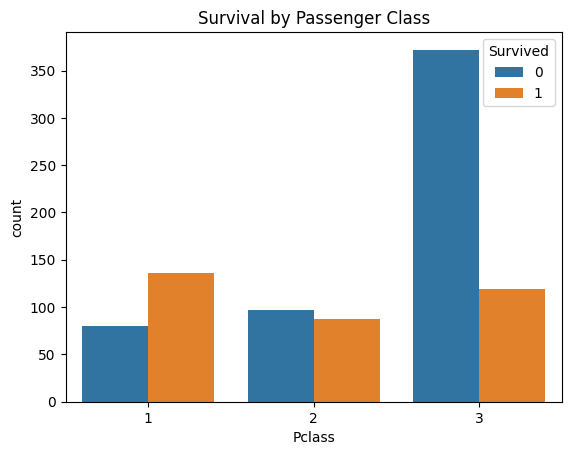

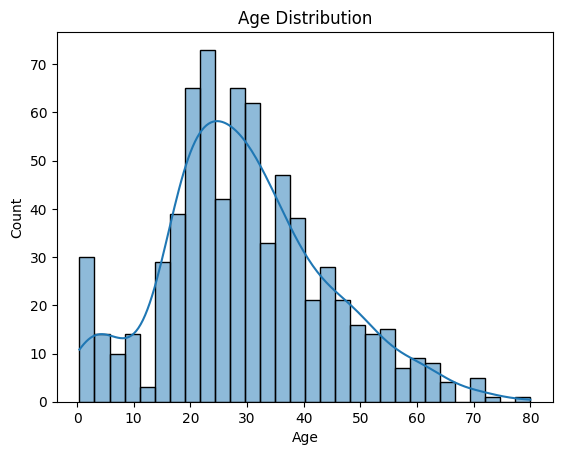

In [ ]:
# Age distribution
sns.histplot(train_df['Age'].dropna(), kde=True, bins=30)
plt.title("Age Distribution")
plt.show()


In [5]:
# Data Preprocessing
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

# Drop unnecessary columns
train_df.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)

# Encode categorical variables
train_df = pd.get_dummies(train_df, drop_first=True)

train_df.head()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,True,False,True
1,2,1,1,38.0,1,0,71.2833,False,False,False
2,3,1,3,26.0,0,0,7.9250,False,False,True
3,4,1,1,35.0,1,0,53.1000,False,False,True
4,5,0,3,35.0,0,0,8.0500,True,False,True


In [6]:
# Split Data
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((712, 9), (179, 9))

In [7]:
# Baseline LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

cv_scores_lgb = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy')
print("LightGBM CV Accuracy:", cv_scores_lgb.mean())


[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [8]:
# Baseline XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print("XGBoost CV Accuracy:", cv_scores_xgb.mean())


XGBoost CV Accuracy: 0.7790345866549494


In [9]:
# Hyperparameter Tuning - LightGBM
param_grid_lgb = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

grid_lgb = GridSearchCV(
    lgb.LGBMClassifier(random_state=42),
    param_grid_lgb,
    cv=3,
    scoring='accuracy',
    verbose=0
)
grid_lgb.fit(X_train, y_train)

print("Best params LightGBM:", grid_lgb.best_params_)
print("Best score LightGBM:", grid_lgb.best_score_)


[LightGBM] [Info] Number of positive: 182, number of negative: 292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383966 -> initscore=-0.472747
[LightGBM] [Info] Start training from score -0.472747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [10]:
# Hyperparameter Tuning - XGBoost
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=3,
    scoring='accuracy',
    verbose=0
)
grid_xgb.fit(X_train, y_train)

print("Best params XGBoost:", grid_xgb.best_params_)
print("Best score XGBoost:", grid_xgb.best_score_)


Best params XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best score XGBoost: 0.8202437092980652


In [11]:
# Evaluate Tuned Models
best_lgb = grid_lgb.best_estimator_
best_xgb = grid_xgb.best_estimator_

y_pred_lgb = best_lgb.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

print("LightGBM (Tuned) F1:", f1_score(y_test, y_pred_lgb))
print("XGBoost (Tuned) F1:", f1_score(y_test, y_pred_xgb))


LightGBM (Tuned) F1: 0.6722689075630253
XGBoost (Tuned) F1: 0.6666666666666666


In [12]:
# Comparative Results
results = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost"],
    "Accuracy": [accuracy_score(y_test, y_pred_lgb), accuracy_score(y_test, y_pred_xgb)],
    "Precision": [precision_score(y_test, y_pred_lgb), precision_score(y_test, y_pred_xgb)],
    "Recall": [recall_score(y_test, y_pred_lgb), recall_score(y_test, y_pred_xgb)],
    "F1 Score": [f1_score(y_test, y_pred_lgb), f1_score(y_test, y_pred_xgb)]
})

results


,Model,Accuracy,Precision,Recall,F1 Score
0,LightGBM,0.782123,0.800000,0.579710,0.672269
1,XGBoost,0.787709,0.844444,0.550725,0.666667


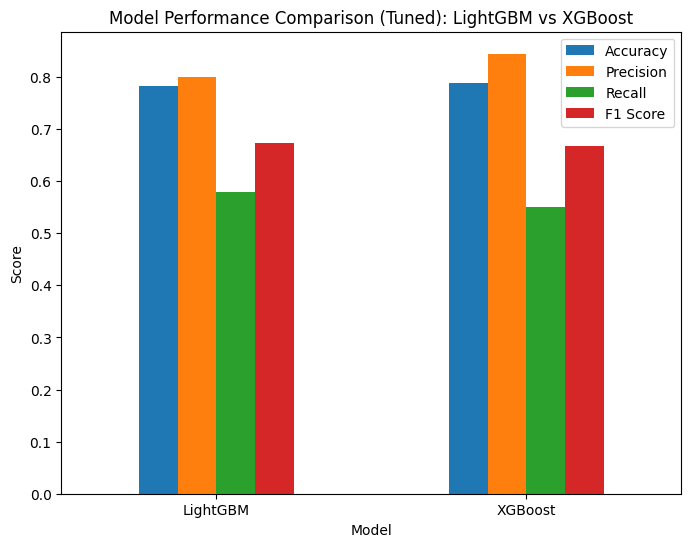

In [13]:
# Visualization of Comparison
results.set_index("Model").plot(kind="bar", figsize=(8,6))
plt.title("Model Performance Comparison (Tuned): LightGBM vs XGBoost")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


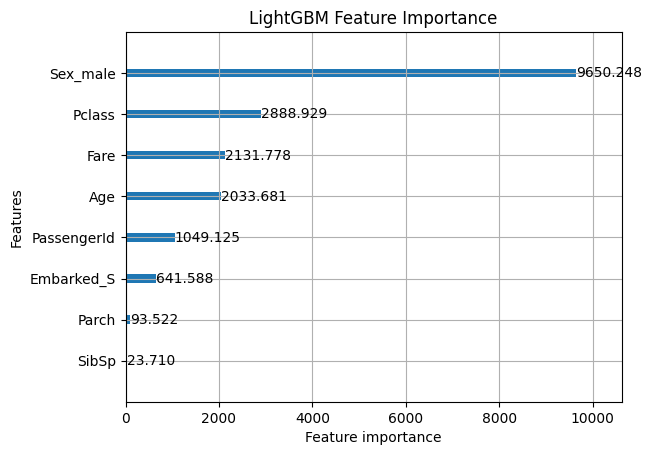

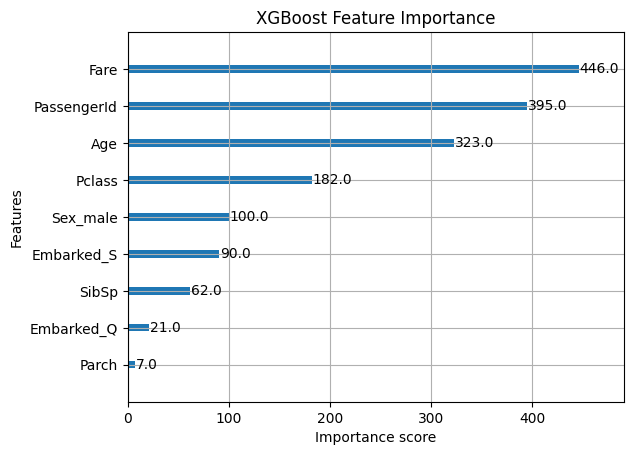

In [14]:
# Feature Importance
lgb.plot_importance(best_lgb, max_num_features=10, importance_type='gain')
plt.title("LightGBM Feature Importance")
plt.show()

xgb.plot_importance(best_xgb, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()
